In [119]:
%matplotlib inline
import matplotlib
import seaborn as sns

## To do
1. Build a model for total taxi traffic in and out of the Loop based on time variables (time of day, day of week)

## Summary

This is the notebook where I build models for taxi traffic based on time.

In [91]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [451]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv('Data/GroupBy.csv')

In [4]:
df.head()

,Unnamed: 0,direction,year,month,day,hour,minute,census_tract,count
0,0,from,2013,1,1,13,15,17031080100,1
1,1,from,2013,1,1,13,15,17031980000,1
2,2,from,2013,1,1,1,30,17031081100,1
3,3,from,2013,1,1,13,45,17031833100,1
4,4,from,2013,1,1,14,0,17031081402,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103159 entries, 0 to 5103158
Data columns (total 9 columns):
Unnamed: 0      int64
direction       object
year            int64
month           int64
day             int64
hour            int64
minute          int64
census_tract    int64
count           int64
dtypes: int64(8), object(1)
memory usage: 350.4+ MB


In [6]:
def make_time(row):
    return datetime(row['year'], row['month'], row['day'],
                    row['hour'], row['minute'])

In [7]:
df['date'] = df.apply(make_time, axis=1)

In [8]:
from_loop_by_date = df[df.direction == 'from'][['date', 'count']].groupby('date').sum().reset_index().set_index('date')

In [9]:
to_loop_by_date = df[df.direction == 'to'][['date', 'count']].groupby('date').sum().reset_index().set_index('date')

In [10]:
from_loop_by_date.head()

,count
date,
2013-01-01 00:00:00,41
2013-01-01 00:15:00,78
2013-01-01 00:30:00,65
2013-01-01 00:45:00,56
2013-01-01 01:00:00,54


In [11]:
to_loop_by_date.head()

,count
date,
2013-01-01 00:00:00,44
2013-01-01 00:15:00,58
2013-01-01 00:30:00,74
2013-01-01 00:45:00,65
2013-01-01 01:00:00,54


Fill nonexistent rows, to make the rows consistently 15 minutes apart

In [12]:
first_date = datetime(2013, 1, 1)
last_date = datetime(2017, 8, 1)

In [13]:
datetime(2013, 1, 1, 0, 15) - first_date

datetime.timedelta(0, 900)

In [14]:
dates = pd.date_range(start=first_date, end=last_date, freq='15Min')

In [15]:
from_absent = [date for date in dates
               if date not in from_loop_by_date.index]

In [16]:
from_loop_by_date = pd.concat([from_loop_by_date,
                               pd.DataFrame([[date, 0] for date in from_absent],
                                            columns=['date', 'count']).set_index('date')]).sort_index()

In [17]:
to_absent = [date for date in dates
             if date not in to_loop_by_date.index]

In [18]:
to_loop_by_date = pd.concat([to_loop_by_date,
                             pd.DataFrame([[date, 0] for date in to_absent],
                                          columns=['date', 'count']).set_index('date')]).sort_index()

In [19]:
df_from_absent = pd.DataFrame(from_absent)
df_to_absent = pd.DataFrame(to_absent)

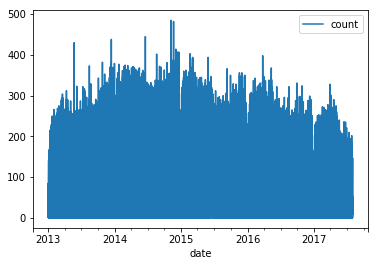

In [20]:
from_loop_by_date.plot()
plt.show()

Do Fourier transform to see patterns. I expect 24-hour, 7-day, and 365-day frequencies.

In [21]:
from scipy import fftpack

In [22]:
from_fft = fftpack.fft(from_loop_by_date['count'] -
                       from_loop_by_date['count'].mean())

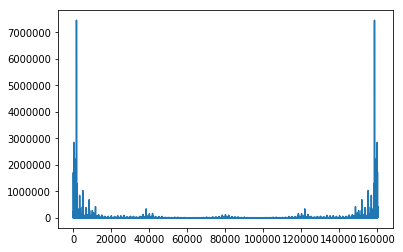

In [23]:
plt.plot(np.abs(from_fft))
plt.show()

There's are big peaks at low frequency. Take a closer look.

In [24]:
freq_year = len(dates) / (365*24*4)
freq_week = len(dates) / (7*24*4)
freq_day = len(dates) / (24*4)

In [25]:
print(freq_year, freq_week, freq_day)

4.583590182648402 239.0014880952381 1673.0104166666667


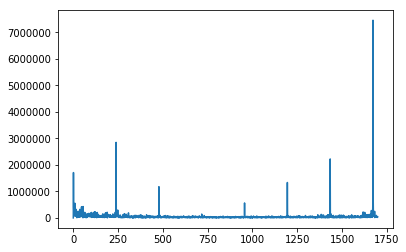

In [26]:
plt.plot(np.abs(from_fft[:1700]))
plt.show()

1 per day gives the biggest Fourier component. The next biggest is the 1 per week frequency.

The first fit is to do OneHotEncoding of day of week and time of day. Look at the residuals to see what else needs to be fit. Try 2 possibilities.

1. Separately encode day of week (7 columns) and time of day (96 columns)
2. Combine the 2 into one variable that I encode (672 columns)

We should expect the time-of-day patterns to be different on weekends, for example. So 2 seems better, but try both. I have enough data that I shouldn't worry  about overfitting (yet).

In [27]:
ohe1 = OneHotEncoder()
ohe2 = OneHotEncoder()

In [28]:
from_loop_by_date = from_loop_by_date.reset_index()

In [29]:
#need categories to go from 0 to N-1
from_loop_by_date['tod'] = from_loop_by_date.reset_index()['date'].apply(
                            lambda x: int(4*x.hour + x.minute/15))
from_loop_by_date['dow'] = from_loop_by_date.reset_index()['date'].apply(
                            lambda x: datetime.weekday(x))

In [30]:
from_loop_by_date.head()

,date,count,tod,dow
0,2013-01-01 00:00:00,41,0,1
1,2013-01-01 00:15:00,78,1,1
2,2013-01-01 00:30:00,65,2,1
3,2013-01-01 00:45:00,56,3,1
4,2013-01-01 01:00:00,54,4,1


In [31]:
X1 = ohe1.fit_transform(from_loop_by_date[['tod', 'dow']])

In [32]:
lr1 = LinearRegression()
lr1.fit(X1, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
pred1 = lr1.predict(X1)

In [34]:
lr1.score(X1, from_loop_by_date['count'])

0.74089509045402013

In [35]:
residual1 = from_loop_by_date['count'] - pred1

In [36]:
residual1.describe()

count    1.606090e+05
mean    -5.545002e-14
std      4.324881e+01
min     -2.137688e+02
25%     -2.679472e+01
50%     -5.790639e+00
75%      2.955615e+01
max      2.746257e+02
Name: count, dtype: float64

In [37]:
#combine 'tod' and 'dow'
from_loop_by_date['time'] = (24*4*from_loop_by_date['dow'] + 
                             from_loop_by_date['tod'])

In [38]:
X2 = ohe1.fit_transform(from_loop_by_date[['time']])

In [39]:
lr2 = LinearRegression()
lr2.fit(X2, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
pred2 = lr2.predict(X2)

In [41]:
lr2.score(X2, from_loop_by_date['count'])

0.84217649895138791

In [42]:
residual2 = from_loop_by_date['count'] - pred2

In [43]:
residual2.describe()

count    1.606090e+05
mean     5.436276e-16
std      3.375376e+01
min     -2.582385e+02
25%     -1.234310e+01
50%     -5.648536e-01
75%      1.391213e+01
max      2.627908e+02
Name: count, dtype: float64

In [44]:
from_loop_by_date['pred1'] = pred1
from_loop_by_date['pred2'] = pred2
from_loop_by_date['residual1'] = residual1
from_loop_by_date['residual2'] = residual2

In [45]:
from_loop_by_date.head()

,date,count,tod,dow,time,pred1,pred2,residual1,residual2
0,2013-01-01 00:00:00,41,0,1,96,54.964620,24.700000,-13.964620,16.300000
1,2013-01-01 00:15:00,78,1,1,97,50.680677,21.121339,27.319323,56.878661
2,2013-01-01 00:30:00,65,2,1,98,45.317856,16.384937,19.682144,48.615063
3,2013-01-01 00:45:00,56,3,1,99,41.298131,13.430962,14.701869,42.569038
4,2013-01-01 01:00:00,54,4,1,100,38.788866,12.016736,15.211134,41.983264


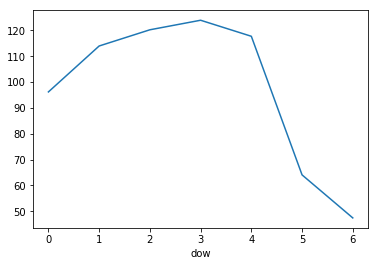

In [46]:
#plot by day of week
from_loop_by_date.groupby('dow').mean()['count'].plot()
plt.show()

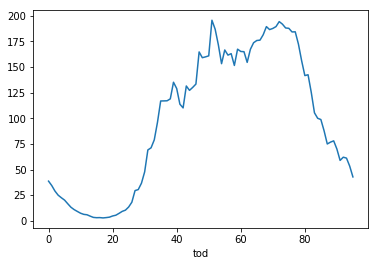

In [47]:
#plot by time of day
from_loop_by_date.groupby('tod').mean()['count'].plot()
plt.show()

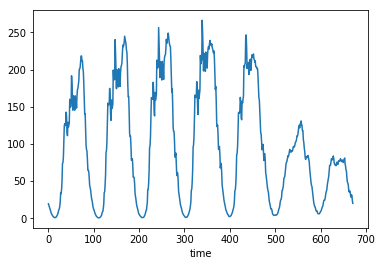

In [48]:
#plot by time (combined)
from_loop_by_date.groupby('time').mean()['count'].plot()
plt.show()

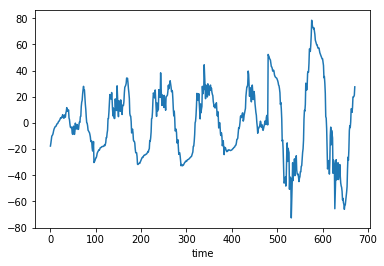

In [49]:
#plot by time (combined)
from_loop_by_date.groupby('time').mean()['residual1'].plot()
plt.show()

As expected, the separate OneHotEncoding strategy misses the weekend traffic by a lot. The combined strategy is designed to fit this perfectly.

2 things to try to fit.
1. Holidays
2. Weather

In [50]:
import holidays

In [60]:
USholidays = holidays.UnitedStates()

In [72]:
from_loop_by_date['holiday'] = from_loop_by_date['date'].apply(
                                lambda x: int(x in USholidays))

In [74]:
from_loop_by_date.groupby('holiday').mean()

,count,tod,dow,time,pred1,pred2,residual1,residual2
holiday,,,,,,,,
0,99.055012,47.499696,3.047371,340.047359,97.530638,97.530635,1.524375,1.524377
1,50.807726,47.500000,1.395833,181.500000,102.414498,102.414580,-51.606772,-51.606854


Add holiday as an additional feature.

In [94]:
X1_hol = scipy.sparse.hstack((X1, from_loop_by_date[['holiday']]))

In [96]:
lr1_hol = LinearRegression()
lr1_hol.fit(X1_hol, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [97]:
lr1_hol.score(X1_hol, from_loop_by_date['count'])

0.75230122966205815

In [98]:
pred1_hol = lr1_hol.predict(X1_hol)

In [100]:
(from_loop_by_date['count'] - pred1_hol).describe()

count    1.606090e+05
mean    -4.131570e-14
std      4.228616e+01
min     -1.841298e+02
25%     -2.755188e+01
50%     -7.632406e+00
75%      2.974001e+01
max      3.037774e+02
Name: count, dtype: float64

In [95]:
X2_hol = scipy.sparse.hstack((X2, from_loop_by_date[['holiday']]))

In [101]:
lr2_hol = LinearRegression()
lr2_hol.fit(X2_hol, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
lr2_hol.score(X2_hol, from_loop_by_date['count'])

0.85358267460343173

In [103]:
pred2_hol = lr2_hol.predict(X2_hol)

In [104]:
(from_loop_by_date['count'] - pred2_hol).describe()

count    1.606090e+05
mean    -1.306373e-11
std      3.251117e+01
min     -2.042563e+02
25%     -1.328545e+01
50%     -1.528125e+00
75%      1.386518e+01
max      2.611620e+02
Name: count, dtype: float64

In [107]:
from_loop_by_date['residual1_hol'] = from_loop_by_date['count'] - pred1_hol
from_loop_by_date['residual2_hol'] = from_loop_by_date['count'] - pred2_hol

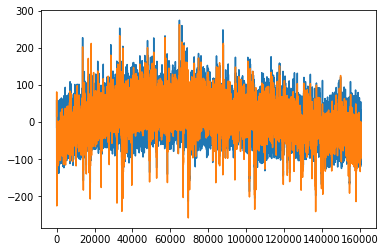

In [120]:
from_loop_by_date['residual1'].plot()
from_loop_by_date['residual2'].plot()
plt.show()

### Weather

In [394]:
df_weather = pd.read_csv('Data/weather.csv').set_index('DATE')

In [395]:
df_weather.head()

,TMAX,TMIN,PRCP,SNOW
DATE,,,,
2013-01-01,26.0,15.0,0.0,0.0
2013-01-02,29.0,14.0,0.0,0.0
2013-01-03,30.0,21.0,0.0,0.0
2013-01-04,37.0,16.0,0.0,0.0
2013-01-05,38.0,25.0,0.0,0.0


Join the weather data

In [396]:
from_loop_by_date['DATE'] = from_loop_by_date['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [397]:
from_loop_by_date = from_loop_by_date.drop(columns=['TMAX', 'TMIN', 'PRCP', 'SNOW'])

In [398]:
from_loop_by_date = from_loop_by_date.join(df_weather, on='DATE')

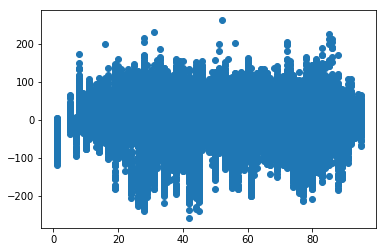

In [399]:
plt.scatter(x=from_loop_by_date['TMAX'], y=from_loop_by_date['residual2'])

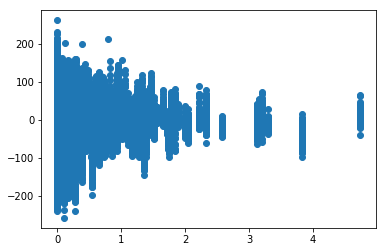

In [400]:
plt.scatter(x=from_loop_by_date['PRCP'], y=from_loop_by_date['residual2'])

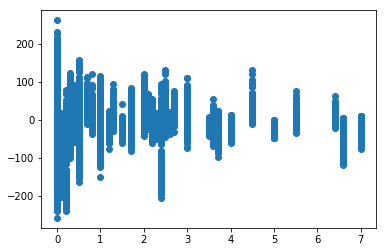

In [401]:
plt.scatter(x=from_loop_by_date['SNOW'], y=from_loop_by_date['residual2'])

In [402]:
from_loop_by_date[['TMAX', 'TMIN', 'PRCP', 'SNOW', 'residual2_hol']].corr()

,TMAX,TMIN,PRCP,SNOW,residual2_hol
TMAX,1.000000,0.950942,0.084631,-0.242964,-0.015480
TMIN,0.950942,1.000000,0.090309,-0.255279,-0.016135
PRCP,0.084631,0.090309,1.000000,0.142562,-0.008494
SNOW,-0.242964,-0.255279,0.142562,1.000000,-0.024052
residual2_hol,-0.015480,-0.016135,-0.008494,-0.024052,1.000000


At the level of linear modeling, there's actually very little correlation between weather and taxi traffic, once you control for time of the year.

### Back to holidays

If you rank days by the residuals, you clearly see Christmas Day, Christmas Eve, and days around Thanksgiving Day showing up with very small traffic, and July 4 with very large traffic. Pretty obvious from common sense, but the model doesn't know.

In [296]:
from_loop_by_date.sort_values('residual2_hol')

,date,count,tod,dow,time,pred1,pred2,residual1,residual2,holiday,residual1_hol,residual2_hol,DATE,TMAX,TMIN,PRCP,SNOW
69459,2014-12-25 12:45:00,8,51,3,339,221.768834,266.238494,-213.768834,-258.238494,1,-159.786781,-204.256349,2014-12-25,42.0,34.0,0.11,0.0
104429,2015-12-24 19:15:00,28,77,3,365,210.501052,225.004184,-182.501052,-197.004184,0,-184.129825,-198.632956,2015-12-24,44.0,36.0,0.54,0.0
69386,2014-12-24 18:30:00,43,74,2,266,210.559548,237.895397,-167.559548,-194.895397,0,-168.257597,-195.593442,2014-12-24,43.0,37.0,0.08,0.0
136755,2016-11-25 12:45:00,54,51,4,435,215.560981,245.037657,-161.560981,-191.037657,0,-162.724391,-192.201065,2016-11-25,42.0,36.0,0.0,0.0
69387,2014-12-24 18:45:00,45,75,2,267,210.194336,234.104603,-165.194336,-189.104603,0,-165.892384,-189.802647,2014-12-24,43.0,37.0,0.08,0.0
136659,2016-11-24 12:45:00,25,51,3,339,221.768834,266.238494,-196.768834,-241.238494,1,-142.786781,-187.256349,2016-11-24,45.0,36.0,0.27,0.0
136756,2016-11-25 13:00:00,61,52,4,436,206.865822,246.535565,-145.865822,-185.535565,0,-147.029233,-186.698973,2016-11-25,42.0,36.0,0.0,0.0
34419,2013-12-25 12:45:00,16,51,2,243,218.072400,256.389121,-202.072400,-240.389121,1,-147.159621,-185.476250,2013-12-25,28.0,18.0,0.0,0.2
136588,2016-11-23 19:00:00,48,76,2,268,206.677899,231.514644,-158.677899,-183.514644,0,-159.375947,-184.212689,2016-11-23,45.0,38.0,0.11,0.0
69460,2014-12-25 13:00:00,12,52,3,340,213.073676,248.225941,-201.073676,-236.225941,1,-147.091622,-182.243797,2014-12-25,42.0,34.0,0.11,0.0


Specifically, add 7/4, 12/24, 12/25, and Thanksgiving Day to start.

In [302]:
from_loop_by_date['doi'] = from_loop_by_date['date'].apply(lambda x: int((x.month == 7) and (x.day == 4)))
from_loop_by_date['che'] = from_loop_by_date['date'].apply(lambda x: int((x.month == 12) and (x.day == 24)))
from_loop_by_date['chd'] = from_loop_by_date['date'].apply(lambda x: int((x.month == 12) and (x.day == 25)))

In [317]:
def checkThanksgiving(date):
    if date in USholidays:
        if USholidays[date] == 'Thanksgiving':
            return 1
        else:
            return 0
    else:
        return 0
from_loop_by_date['thg'] = from_loop_by_date['date'].apply(checkThanksgiving)

In [319]:
X2_more = scipy.sparse.hstack((X2_hol, from_loop_by_date[['doi', 'thg', 'che', 'chd']]))

In [320]:
lr2_more = LinearRegression()
lr2_more.fit(X2_more, from_loop_by_date['count'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [321]:
lr2_more.score(X2_more, from_loop_by_date['count'])

0.85653712551928596

In [425]:
lr2_more.coef_

array([ -7.29304610e+01,  -7.50141430e+01,  -7.74241849e+01,
        -7.90392476e+01,  -8.09388292e+01,  -8.27421765e+01,
        -8.51354820e+01,  -8.67463606e+01,  -8.77212560e+01,
        -8.87379924e+01,  -8.95999171e+01,  -9.03488711e+01,
        -9.06752309e+01,  -9.13321347e+01,  -9.15706284e+01,
        -9.14283690e+01,  -9.12819255e+01,  -9.08342267e+01,
        -8.96333899e+01,  -8.90392476e+01,  -8.72359004e+01,
        -8.58718836e+01,  -8.30057748e+01,  -8.07296242e+01,
        -7.98509631e+01,  -7.58886200e+01,  -7.08509631e+01,
        -5.81354820e+01,  -5.91856912e+01,  -5.35287874e+01,
        -4.25831807e+01,  -1.87212560e+01,  -1.77087037e+01,
        -1.06041012e+01,   9.65531303e+00,   3.17348109e+01,
         3.46720494e+01,   3.20025934e+01,   3.47766519e+01,
         5.02494553e+01,   4.49482001e+01,   2.35256059e+01,
         1.86887858e+01,   3.66971540e+01,   3.00779072e+01,
         3.25967356e+01,   3.56134720e+01,   6.75716310e+01,
         5.72117984e+01,

In [322]:
pred2_more = lr2_more.predict(X2_more)

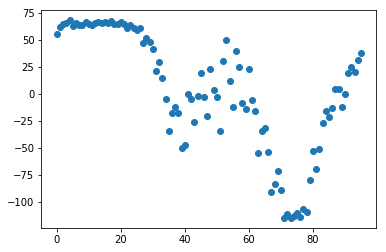

In [447]:
plt.scatter(from_loop_by_date[from_loop_by_date['DATE'] == '2013-12-24']['tod'],
           from_loop_by_date[from_loop_by_date['DATE'] == '2013-12-24']['residual2_more'])

In [323]:
from_loop_by_date['residual2_more'] = from_loop_by_date['count'] - pred2_more

In [421]:
from_loop_by_date.sort_values('residual2_more')

,date,count,tod,dow,time,pred1,pred2,residual1,residual2,holiday,...,DATE,doi,che,chd,thg,residual2_more,TMAX,TMIN,PRCP,SNOW
136755,2016-11-25 12:45:00,54,51,4,435,215.560981,245.037657,-161.560981,-191.037657,0,...,2016-11-25,0,0,0,0,-192.225330,42.0,36.0,0.00,0.0
136756,2016-11-25 13:00:00,61,52,4,436,206.865822,246.535565,-145.865822,-185.535565,0,...,2016-11-25,0,0,0,0,-186.723238,42.0,36.0,0.00,0.0
136588,2016-11-23 19:00:00,48,76,2,268,206.677899,231.514644,-158.677899,-183.514644,0,...,2016-11-23,0,0,0,0,-184.584506,45.0,38.0,0.11,0.0
147,2013-01-02 12:45:00,75,51,2,243,218.072400,256.389121,-143.072400,-181.389121,0,...,2013-01-02,0,0,0,0,-182.458983,29.0,14.0,0.00,0.0
69555,2014-12-26 12:45:00,64,51,4,435,215.560981,245.037657,-151.560981,-181.037657,0,...,2014-12-26,0,0,0,0,-182.225330,50.0,38.0,0.00,0.0
72,2013-01-01 18:00:00,19,72,1,168,210.482231,244.815900,-191.482231,-225.815900,1,...,2013-01-01,0,0,0,0,-180.539933,26.0,15.0,0.00,0.0
74,2013-01-01 18:30:00,18,74,1,170,204.289763,238.430962,-186.289763,-220.430962,1,...,2013-01-01,0,0,0,0,-175.154996,26.0,15.0,0.00,0.0
73,2013-01-01 18:15:00,25,73,1,169,208.004646,241.619247,-183.004646,-216.619247,1,...,2013-01-01,0,0,0,0,-171.343280,26.0,15.0,0.00,0.0
136587,2016-11-23 18:45:00,65,75,2,267,210.194336,234.104603,-145.194336,-169.104603,0,...,2016-11-23,0,0,0,0,-170.174464,45.0,38.0,0.11,0.0
34515,2013-12-26 12:45:00,102,51,3,339,221.768834,266.238494,-119.768834,-164.238494,0,...,2013-12-26,0,0,0,0,-167.016038,35.0,16.0,0.04,0.5


In [404]:
from_loop_by_date[from_loop_by_date['tod'] == 80][['residual2_hol', 'TMAX']].corr().iloc[0, 1]

-0.0066991750142249562

In [412]:
test_corr = np.array([from_loop_by_date[from_loop_by_date['tod'] == tod][['residual2_hol', 'TMAX', 'TMIN', 'PRCP', 'SNOW']].corr().iloc[0, 1:5] for tod in range(4*24)])

In [413]:
test_corr

array([[  1.49163817e-01,   1.65681717e-01,  -3.85056385e-03,
         -2.63331673e-02],
       [  1.85494366e-01,   1.97949331e-01,  -2.14134021e-02,
         -4.38810187e-02],
       [  1.89606454e-01,   1.99670805e-01,  -1.18866094e-02,
         -5.10566550e-02],
       [  2.04225658e-01,   2.15254575e-01,  -5.30409750e-03,
         -4.68541700e-02],
       [  2.03416313e-01,   2.13803856e-01,   9.69015630e-03,
         -2.95561495e-02],
       [  1.65578647e-01,   1.73132731e-01,  -8.99589096e-03,
         -2.53906263e-02],
       [  1.24482916e-01,   1.32891758e-01,  -1.85575412e-02,
         -1.87629929e-02],
       [  9.93005499e-02,   1.07593506e-01,  -2.56254235e-02,
          4.14962697e-03],
       [  8.54513143e-02,   9.59715531e-02,  -3.18589702e-02,
         -7.53185652e-03],
       [  7.53138395e-02,   8.42167342e-02,  -2.67637298e-02,
         -9.00866728e-03],
       [  4.36262607e-02,   5.56355088e-02,  -3.23303267e-02,
         -5.45714430e-03],
       [  4.07876773e

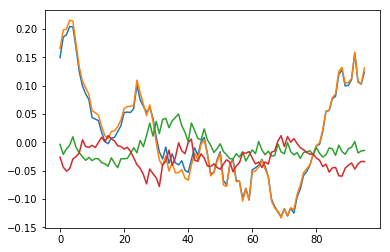

In [420]:
plt.plot(test_corr)
plt.show()

Blue (TMAX) and orange (TMIN) have the same clear pattern. More people take the taxi late at night when it's warm, and in the afternoon when it's cold. Makes sense. There needs to be some nonlinearity to take this into account.

There also seems to be a pattern from precipitation, but it's small.

In [452]:
#train a simple neural network
pipeline0 = Pipeline([('Scaler', StandardScaler()),
                     ('NN', MLPRegressor())])

In [453]:
pipeline0.get_params()

{'NN': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(100,), learning_rate='constant',
        learning_rate_init=0.001, max_iter=200, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False),
 'NN__activation': 'relu',
 'NN__alpha': 0.0001,
 'NN__batch_size': 'auto',
 'NN__beta_1': 0.9,
 'NN__beta_2': 0.999,
 'NN__early_stopping': False,
 'NN__epsilon': 1e-08,
 'NN__hidden_layer_sizes': (100,),
 'NN__learning_rate': 'constant',
 'NN__learning_rate_init': 0.001,
 'NN__max_iter': 200,
 'NN__momentum': 0.9,
 'NN__nesterovs_momentum': True,
 'NN__power_t': 0.5,
 'NN__random_state': None,
 'NN__shuffle': True,
 'NN__solver': 'adam',
 'NN__tol': 0.0001,
 'NN__validation_fraction': 0.1,
 'NN__verbose': False,
 'NN__warm_start': False,
 'Scale

In [455]:
gs0 = GridSearchCV(pipeline0,
                   param_grid={'NN__alpha': [.00001, .0001, .001, .01],
                              'NN__hidden_layer_sizes': [1, 2, 5, 10]})

In [459]:
gs0 = GridSearchCV(MLPRegressor(),
                   param_grid={'alpha': [.00001, .0001, .001, .01],
                              'hidden_layer_sizes': [1, 2, 5, 10]})

In [460]:
gs0.fit(X2_more, from_loop_by_date['count'])

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/neural_net

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01], 'hidden_layer_sizes': [1, 2, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [463]:
print(gs0.best_params_, gs0.best_score_)

{'alpha': 0.01, 'hidden_layer_sizes': 2} 0.824271438803


In [464]:
gs0.best_estimator_.score(X2_more, from_loop_by_date['count'])

0.85653025002181005

In [470]:
gs0.best_estimator_.fit(X2_more, from_loop_by_date['count'])

MLPRegressor(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [472]:
residual_nn = from_loop_by_date['count'] - gs0.best_estimator_.predict(X2_more)

In [473]:
residual_nn.describe()

count    160609.000000
mean          0.343442
std          32.182386
min        -190.794947
25%         -12.878532
50%          -1.464455
75%          14.154554
max         260.475035
Name: count, dtype: float64

In [469]:
from_loop_by_date['residual2_more'].describe()

count    1.606090e+05
mean    -7.610234e-09
std      3.218149e+01
min     -1.922253e+02
25%     -1.326233e+01
50%     -1.702231e+00
75%      1.382227e+01
max      2.600133e+02
Name: residual2_more, dtype: float64

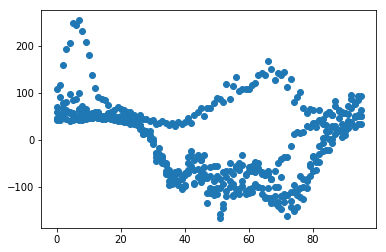

In [474]:
plt.scatter(from_loop_by_date[from_loop_by_date['doi'] == 1]['tod'],
           residual_nn[from_loop_by_date['doi'] == 1])

Adding nonlinearity to the time features doesn't do anything.

Include weather.

In [491]:
ss = StandardScaler()
X_weather_ss = ss.fit_transform(df_weather)

In [492]:
X_weather_ss

array([[-1.55465463, -1.53276454, -0.36593936, -0.16883926],
       [-1.40485943, -1.58572431, -0.36593936, -0.16883926],
       [-1.3549277 , -1.21500593, -0.36593936, -0.16883926],
       ..., 
       [ 1.14165895,  1.32706298, -0.36593936, -0.16883926],
       [ 1.09172721,  1.32706298, -0.36593936, -0.16883926],
       [-0.05670264, -0.04989101, -0.03794588, -0.16883926]])

In [489]:
#join X2_more with X_weather_ss
X3 = scipy.sparse.hstack((X2_more, X_weather_ss))

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1674, expected 160609.

In [484]:
X2_more.shape

(160609, 677)

(1674, 4)